<a href="https://colab.research.google.com/github/frankovacevich/ObjectDetectionRepo/blob/master/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection

This is some code to test the Object Detection algorithm. The idea is to go through all the main steps to get a neural network that performs Object Detection.

I have uploaded everything to my Github repo (cloned in step 0).

My repo: https://github.com/frankovacevich/ObjectDetectionRepo

Example: https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10

Tensorflow API: https://github.com/tensorflow/models

Detection Zoo Model: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md




####Step 0. Import libraries and load repo

In [0]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

from datetime import datetime
class showprogress():
  n = 0
  i = 0
  t = 0
  
  def done(self):
    print(" Done. (" + str((datetime.now() - self.t).total_seconds()) + "s)", end="", flush=True)
  
  def update(self):
    if self.n==0: return
    self.i += 1
    if self.i==self.n:
      print("|",end="",flush=True)
      self.i = 0
  
  def __init__(self, print_step = 1):
    self.n = print_step
    print("Progress: ", end="", flush=True)
    self.t = datetime.now()

In [106]:
#LOAD REPOSITORY FROM MY GITHUB PAGE
!rm -rf ObjectDetectionRepo
!git clone https://github.com/frankovacevich/ObjectDetectionRepo;

Cloning into 'ObjectDetectionRepo'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1094 (delta 0), reused 0 (delta 0), pack-reused 1092
Receiving objects: 100% (1094/1094), 194.24 MiB | 31.04 MiB/s, done.
Resolving deltas: 100% (22/22), done.


####Step 1. Create image set

**1.1. Images.** The first step is to create a set of images, which is then subdivided into the training set (~70%) and test (~30%). We display one of the images of the training set here. *So far we've got just the plain images*.

**How many Images should we have to train our neural network?**

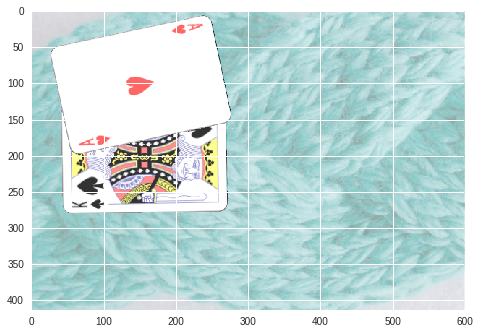

In [107]:
# Example of the images used for training
img=mpimg.imread('ObjectDetectionRepo/images/train/IMG_44.png')
plt.imshow(img)

**1.2. Metadata and labels**. We have to generate a metadata file(s) to indicate the size of the picture, the class, where the object is located in the picture, etc. This metadata file(s) will be fed to the next step (Generate TFRecords) to get the file that will be the (training or test) input of our neural network. 

*Here I created for each file a metadata file with the same name for each image, located in the same folder. The important thing is to be able to read the metadata to generate the TFRecord*

In the metadata we define the class of each object (in our case, the type of card). The class can be expressed as a text (`class_name`) or as an integer (`class_label`). We have to build a function (`get_class_label`) to relate the `class_name` and the `class_number`.

In [108]:
# Example of a metadata file (for the image above)
metadata = open('ObjectDetectionRepo/images/train/IMG_44.txt','r',encoding='UTF8')
s = metadata.read()
print(s)

file: ObjectDetectionRepo/images/train/IMG_44.png
width: 600
height: 414
class: Ks
xmin: 42
xmax: 272
ymin: 125
ymax: 280
class: Ah
xmin: 25
xmax: 279
ymin: 3
ymax: 199


In [0]:
def get_class_label(class_name):
  #Retuns the label (as a number) for each class
  
  class_label = 0
  
  n = 13
  if class_name.startswith("K"): class_label += 13
  if class_name.startswith("Q"): class_label += 12
  if class_name.startswith("J"): class_label += 11
  if class_name.startswith("10"): class_label += 10
  if class_name.startswith("9"): class_label += 9
  if class_name.startswith("8"): class_label += 8
  if class_name.startswith("7"): class_label += 7
  if class_name.startswith("6"): class_label += 6
  if class_name.startswith("5"): class_label += 5
  if class_name.startswith("4"): class_label += 4
  if class_name.startswith("3"): class_label += 3
  if class_name.startswith("2"): class_label += 2
  if class_name.startswith("A"): class_label += 1
  if class_name.startswith("joker"): class_label += 0
    
  if class_name.endswith("s"): class_label += 0*n #spades
  if class_name.endswith("h"): class_label += 1*n #hearts
  if class_name.endswith("c"): class_label += 2*n #clubs
  if class_name.endswith("d"): class_label += 3*n #diamonds
    
  return class_label

####Step 2. Generate TFRecords

We have to label all the images in our sets. The label is what defines the 'output' for the algorithm, that is, the answer to what you're seeing in each picture. For

In [114]:
# ==============================================================================
# SOME FUNCTIONS AND CLASSES
# ==============================================================================
class record:
  filename = 0
  image_format = 0
  encoded_image = 0
  height = 0
  width = 0
  
  classes_names = []
  classes_labels = []
  
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  
  def __init__(self):
    self.classes_names = []
    self.classes_labels = []
    self.xmins = []
    self.xmaxs = []
    self.ymins = []
    self.ymaxs = []

def int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def bytes_list_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def float_list_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))
    
def get_extension(filename):
  return filename[filename.rfind(".")+1:]

def rem_extension(filename):
  return filename[:filename.rfind(".")]

def encode_image(filename):
  return tf.gfile.GFile(filename, 'rb').read()

def get_record_from_file(file):
  new_record = record()
  for line in file:
    line = line.replace("\n","")
    if line.startswith("height: "):
      height = int(line[8:])
      new_record.height = height 
      
    if line.startswith("width: "):
      width = int(line[7:])
      new_record.width = width
      
    if line.startswith("file: "): 
      new_record.filename = rem_extension(line[6:]).encode('utf8')
      new_record.image_format = bytes(get_extension(line[6:]).encode('utf8'))
      new_record.encoded_image = encode_image(line[6:])
      
    if line.startswith("class: "): 
      new_record.classes_names.append(line[7:].encode('utf8'))
      new_record.classes_labels.append(get_class_label(line[7:]))
      
    if line.startswith("xmin: "): new_record.xmins.append(float(line[6:]) / width)
    if line.startswith("xmax: "): new_record.xmaxs.append(float(line[6:]) / width)
    if line.startswith("ymin: "): new_record.ymins.append(float(line[6:]) / height)
    if line.startswith("ymax: "): new_record.ymaxs.append(float(line[6:]) / height)
   
  return new_record
    
def encode_record(record):
  tf_record = tf.train.Example(features = tf.train.Features(feature={
      'image/height': int64_feature(record.height),
      'image/width': int64_feature(record.width),
      'image/filename': bytes_feature(record.filename),
      'image/source_id': bytes_feature(record.filename),
      'image/encoded': bytes_feature(record.encoded_image),
      'image/format': bytes_feature(record.image_format),
      'image/object/bbox/xmin': float_list_feature(record.xmins),
      'image/object/bbox/xmax': float_list_feature(record.xmaxs),
      'image/object/bbox/ymin': float_list_feature(record.ymins),
      'image/object/bbox/ymax': float_list_feature(record.ymaxs),
      'image/object/class/text': bytes_list_feature(record.classes_names),
      'image/object/class/label': int64_list_feature(record.classes_labels),
  }))
  return tf_record
    
# ==============================================================================
# MAIN 
# ==============================================================================

writer = tf.python_io.TFRecordWriter("ObjectDetectionRepo/images/train.record")
path = os.path
pb = showprogress(10)

for filename in os.listdir("ObjectDetectionRepo/images/train"):
  if get_extension(filename) == "txt":
    with open("ObjectDetectionRepo/images/train/" + filename,'r',encoding="UTF8") as f:
      pb.update()
      
      this_record = get_record_from_file(f)
      encoded_record = encode_record(this_record)
      writer.write(encoded_record.SerializeToString())
      f.close()  
      
writer.close()
pb.done()
   


Progress: |||||||||| Done. (0.198917s)

####Step 3. Configure training

In this step we will define:
- Model
- 